In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, mean_squared_log_error
import math


In [23]:

# Load the CSV data
df = pd.read_csv('./data/cleaned_weekly_stock_market.csv')


In [24]:

# Filter the data for selected companies
companies = [
    'AMEN BANK', 'ARTES', 'ASSAD', 'BIAT', 'BANQUE DE TUNISIE',
    'EURO-CYCLES', 'SOTUMAG', 'ONE TECH', 'SAH', 'SFBT',
    'SOMOCER', 'SOTETEL', 'SOTUVER', 'TUNISAIR',
    'BANQUE ATTIJARI DE TUNIS', 'TELNET HOLDING', 'TPR', 'UIB'
]


In [25]:

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))


In [26]:

# Prepare the data for all selected companies
dataframes = []
for company in companies:
    company_data = df[df['companyName'] == company].reset_index()['closingPrice']
    company_data = scaler.fit_transform(np.array(company_data).reshape(-1, 1))
    dataframes.append(company_data)


In [27]:

# Combine the data into a single array
combined_data = np.vstack(dataframes)


In [28]:

# Split the data into training and testing sets
training_size = int(len(combined_data) * 0.65)
train_data, test_data = combined_data[0:training_size, :], combined_data[training_size:len(combined_data), :1]


In [29]:

# Function to create a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [30]:

# Create datasets
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [31]:

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [32]:

# Normalize target values
y_train = scaler.transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))


In [33]:

# Build the LSTM model with Dropout layers
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')
model.summary()


/home/firas/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [35]:

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=64, verbose=1, callbacks=[early_stopping])


Epoch 1/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0327 - val_loss: 3.9349e-04
Epoch 2/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0037 - val_loss: 3.7963e-05
Epoch 3/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 4/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 5/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 6/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0014 - val_loss: 9.9713e-04
Epoch 7/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 8/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0011 - val_loss: 1.2210e-04
Epoch 9/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 8.7911e-04 - val_loss: 8.2326e-05
Epoch 10/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 7.6995e-04 - val_loss: 3.9007e-05
Epoch 11/200
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 6.8659e-04 - val_loss: 5.6987e-04
Epoch 12/200

In [36]:

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [37]:

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)


In [38]:

# Calculate RMSE and MAE
train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)


In [40]:

from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

# Additional evaluations
train_r2 = r2_score(y_train_actual, train_predict)
test_r2 = r2_score(y_test_actual, test_predict)
train_explained_var = explained_variance_score(y_train_actual, train_predict)
test_explained_var = explained_variance_score(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train R^2: {train_r2}")
print(f"Test R^2: {test_r2}")
print(f"Train Explained Variance: {train_explained_var}")
print(f"Test Explained Variance: {test_explained_var}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Train RMSE: 0.14134017623790604
Test RMSE: 0.14510198629563023
Train MAE: 0.11245156820608507
Test MAE: 0.11693814983508376
Train R^2: 0.6894325744084526
Test R^2: 0.6281585842308036
Train Explained Variance: 0.7866238953666854
Test Explained Variance: 0.7480718254690014
Train MSE: 0.01997704541896234
Test MSE: 0.021054586426937263


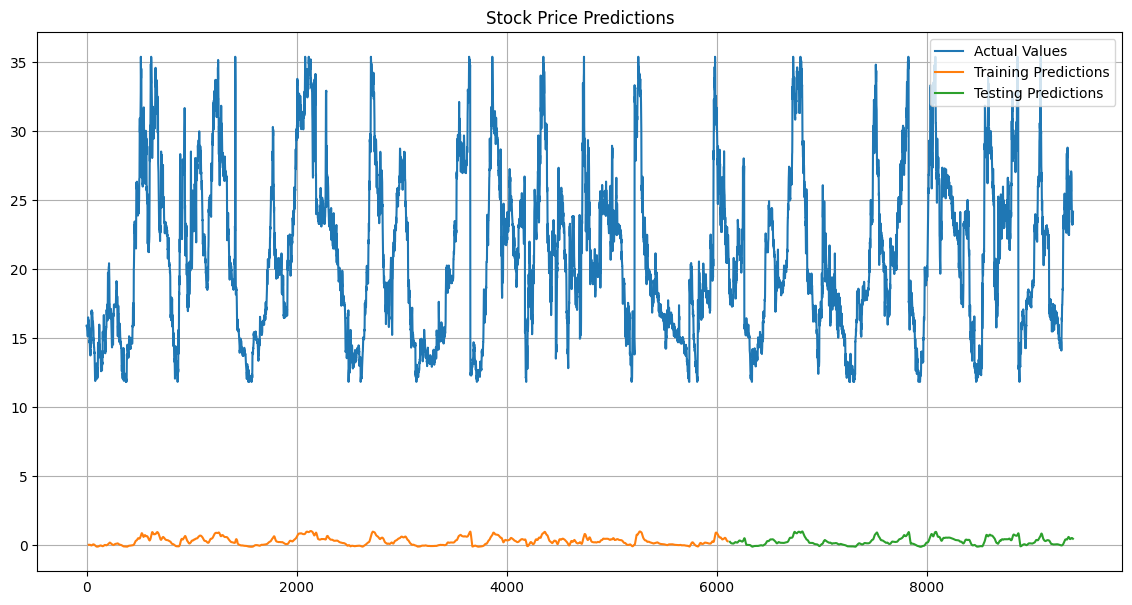

In [41]:

# Plotting
look_back = time_step
trainPredictPlot = np.empty_like(combined_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(combined_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(combined_data) - 1, :] = test_predict

plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(combined_data), label='Actual Values')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.legend()
plt.grid(True)
plt.title('Stock Price Predictions')
plt.show()


In [42]:

# Predict the next 10 days
n_steps = 20
x_input = test_data[len(test_data) - n_steps:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
for i in range(10):
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())


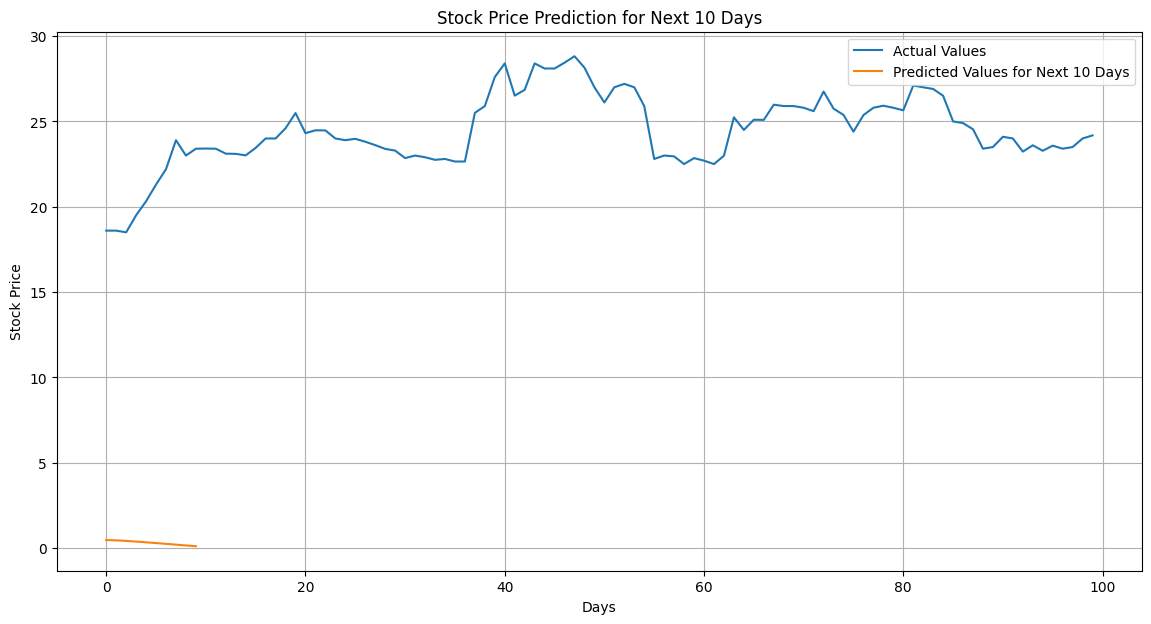

In [43]:

# Plot the last 100 actual values and the predicted values for the next 10 days
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(combined_data[len(combined_data)-100:]), label='Actual Values')
plt.plot(scaler.inverse_transform(lst_output), label='Predicted Values for Next 10 Days')
plt.title('Stock Price Prediction for Next 10 Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


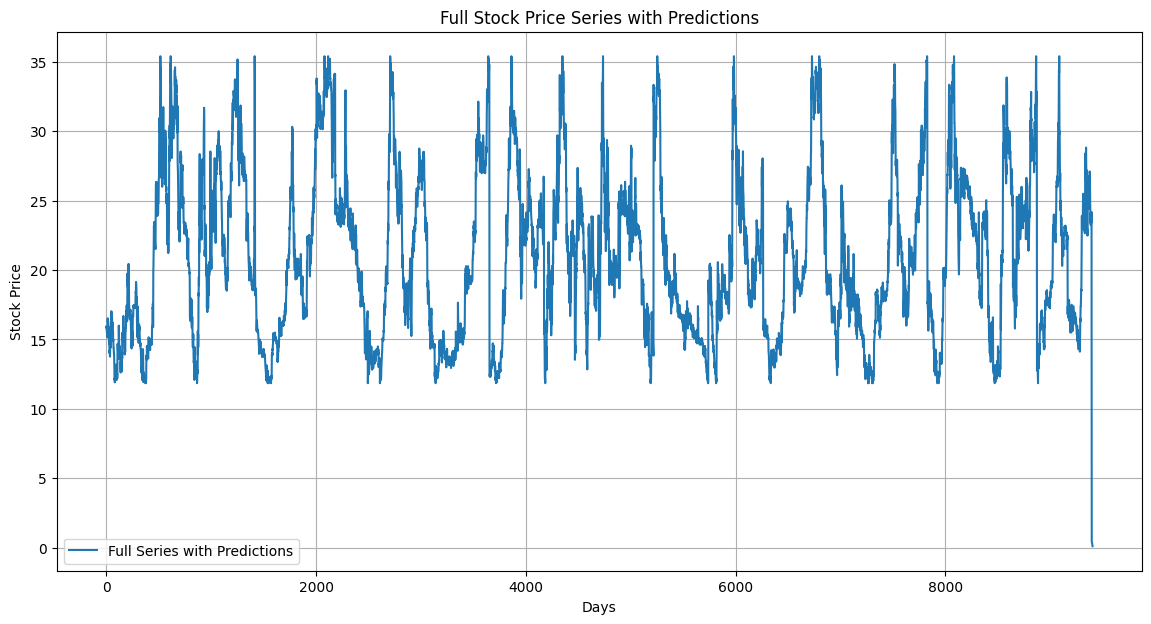

In [44]:

# Full visualization including all data points and predictions
stock_pred = combined_data.tolist()
stock_pred.extend(lst_output)
plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(stock_pred), label='Full Series with Predictions')
plt.title('Full Stock Price Series with Predictions')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()
